# SageMaker Endpoint에 사전 훈련된 모델을 호스팅 후 Object Deteciton 수행하기 (TensorFlow)
---

*본 노트북은 AWS 머신러닝 블로그 [Performing batch inference with TensorFlow Serving in Amazon SageMaker](https://aws.amazon.com/ko/blogs/machine-learning/performing-batch-inference-with-tensorflow-serving-in-amazon-sagemaker/)를 참조하여 핸즈온 랩(Hands-on Lab)에 적합하게 새롭게 구성하였습니다.*

Amazon SageMaker에서 추론(inference)을 수행하려면 반드시 SageMaker에서 먼저 훈련을 수행해야 하나요? 그렇지 않습니다.<br>
만약 여러분이 SageMaker에서 추론만 수행하고 싶다면, 여러분의 온프레미스(on-premise)에서 훈련한 모델이나 공개 모델 저장소(model zoo)에 저장되어 있는 사전 훈련된(pre-trained) 모델들을 도커(Docker) 이미지 빌드 없이 그대로 SageMaker Endpoint에 배포할 수 있습니다. 
여러분이 수행할 작업은 오로지 추론용 엔트리포인트(entrypoint)만 작성하는 것입니다.

우선, TensorFlow 엔트리포인트 인터페이스에 대해 간단히 살펴 보도록 하겠습니다. 

- `input_handler(data, context)`: TensorFlow Serving REST API로 전송되기 전에 입력 데이터에 대한 전처리를 수행합니다. (예: data로 전송된 bytearray 배열을 PIL.Image로 변환 수 cropping, resizing, normalization등의 전처리 수행). context.request_content_type은 입력 데이터 종류에 따라 다양하게 처리 가능합니다. (예: application/x-npy, application/json, application/csv 등)
- `output_handler(data, context)`: TensorFlow Serving의 추론 결과를 추가 변환을 거쳐 프론트 엔드로 전송합니다. 

이 노트북에서는 [TensorFlow model zoo](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md)에서 제공하고 있는 Object Detection 모델들 중 `ssd_mobilenet_v2_coco` 모델을 가져와 Endpoint에 모델을 배포하여 추론을 수행해 보겠습니다.
 
대용량 데이터셋에 대한 배치 변환(batch transform) TensorFlow 추론 예시는 AWS 머신러닝 블로그 [Performing batch inference with TensorFlow Serving in Amazon SageMaker](https://aws.amazon.com/ko/blogs/machine-learning/performing-batch-inference-with-tensorflow-serving-in-amazon-sagemaker/)를 참조해 주세요.

## Pre-requisites

- 기본 용법: [TensorFlow](https://www.tensorflow.org/tutorials)
- AWS 서비스: [AWS S3](https://docs.aws.amazon.com/s3/index.html), [Amazon SageMaker](https://aws.amazon.com/sagemaker/)

<br>

# 1. Deployment
----


## SavedModel 다운로드 및 확인

TensorFlow Model zoo의 `mobilenet_v2` 모델 아티팩트(model artifact)를 로컬 공간으로 복사하여 압축을 해제합니다. 이 모델 아티팩트는
TensorFlow SavedModel(https://www.tensorflow.org/guide/saved_model) 을 포함하고 있습니다. 물론 Model zoo에는 다른 모델들도 제공되어 있으니 향후 다른 모델로 변경해서 자유롭게 실험하셔도 좋습니다. <br>
압축을 해제하면 아래 구조의 디렉토리들과 파일들을 확인할 수 있습니다.
```
.
├── checkpoint
├── frozen_inference_graph.pb
├── model.ckpt.data-00000-of-00001
├── model.ckpt.index
├── model.ckpt.meta
├── pipeline.config
└── saved_model
    ├── saved_model.pb
    └── variables
```


In [1]:
%%bash

wget -q http://download.tensorflow.org/models/object_detection/ssd_mobilenet_v2_coco_2018_03_29.tar.gz
tar zxvf ssd_mobilenet_v2_coco_2018_03_29.tar.gz

ssd_mobilenet_v2_coco_2018_03_29/checkpoint
ssd_mobilenet_v2_coco_2018_03_29/model.ckpt.meta
ssd_mobilenet_v2_coco_2018_03_29/pipeline.config
ssd_mobilenet_v2_coco_2018_03_29/saved_model/saved_model.pb
ssd_mobilenet_v2_coco_2018_03_29/frozen_inference_graph.pb
ssd_mobilenet_v2_coco_2018_03_29/saved_model/
ssd_mobilenet_v2_coco_2018_03_29/saved_model/variables/
ssd_mobilenet_v2_coco_2018_03_29/model.ckpt.index
ssd_mobilenet_v2_coco_2018_03_29/
ssd_mobilenet_v2_coco_2018_03_29/model.ckpt.data-00000-of-00001


사전 훈련된 모델 파일들 중 `saved_model` 디렉토리 내 모델 아티팩트(model artifact)인 `saved_model.pb`와 그 하위 디렉토리인
`variables` 디렉토리만 TFS 컨테이너에 필요합니다.
본 노트북에서는 폴더 이름을 저장된 모델 버전 번호(본 노트북에서는 `1` 부여)로 변환하겠습니다.

In [2]:
!mv ssd_mobilenet_v2_coco_2018_03_29/saved_model ssd_mobilenet_v2_coco_2018_03_29/1

SageMaker의 TFS 컨테이너는 TensorFlow SavedModel을 내보낼 때 선언되는 serving_default 모델의 SignatureDef를 사용합니다. <br>
`saved_model_cli show`를 통해 어떤 값이 입력으로 들어가고 어떤 값들이 출력되는지 확인하실 수 있습니다.

In [3]:
!saved_model_cli show --dir ssd_mobilenet_v2_coco_2018_03_29/1/ --all



MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['inputs'] tensor_info:
        dtype: DT_UINT8
        shape: (-1, -1, -1, 3)
        name: image_tensor:0
  The given SavedModel SignatureDef contains the following output(s):
    outputs['detection_boxes'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 100, 4)
        name: detection_boxes:0
    outputs['detection_classes'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 100)
        name: detection_classes:0
    outputs['detection_scores'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 100)
        name: detection_scores:0
    outputs['num_detections'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1)
        name: num_detections:0
  Method name is: tensorflow/serving/predict


## Pre/post-processing inference script

SageMaker TFS 컨테이너는 기본적으로 REST API를 사용하여 추론 요청을 제공하며 데이터 pre-processing 및 post-processing 스크립트 기능을 제공하기 때문에 직접 도커 컨테이너를 빌드하여 Amazon ECR(Elastic Container Registry)에 업로드할 필요가 없습니다.
여러분은 엔트리포인트(entrypoint) 스크립트만 구현하시면 됩니다.

- 스크립트 구현; `inference.py`내의 `input_handler` 및 `output_handler` 인터페이스 구현
- 스크립트가 특정 패키지에 의존할 때 선택적으로 `requirements.txt` 파일 작성

그 다음, `inference.py`와 `requirements.txt`을 `code` 디렉토리에 포함하면 모든 준비가 끝난 것입니다.

`input_handler` 및 `output_handler`에 대한 자세한 내용은 [SageMaker TensorFlow Serving 컨테이너 README](https://github.com/aws/sagemaker-tensorflow-serving-container/blob/master/README.md)를 참조하십시오.

먼저 `inference.py` 파일을 살펴보겠습니다.<br>
입력 pre-processing 측에서는 입력 데이터를 필요한 TFS REST API 입력 형식으로 변환하고, 출력 post-processing 측에서는 클라이언트에게 표준 TFS 형식으로 예측 결과를 전달합니다. 본 노트북에서는 영상 데이터에 대한 스크립트를 제공하고 있지만, TFS는 TFRecord 형식의 입력 데이터도 받을 수 있기 때문에 여러분이 입력 데이터 형식에 맞게 자유롭게 스크립트를 구성하실 수 있습니다. 

```
Endpoint Request -> inference.py -> Endpoint Response
                    ├── input_handler()
                    ├── actual inference on container
                    └── output_handler()
```

In [4]:
%%writefile code/inference.py
import base64
import io
import json
import requests
from PIL import Image
import numpy as np

def input_handler(data, context):
    """ Pre-process request input before it is sent to TensorFlow Serving REST API

    Args:
        data (obj): the request data stream
        context (Context): an object containing request and configuration details

    Returns:
        (dict): a JSON-serializable dict that contains request body and headers
    """

    if context.request_content_type == 'application/x-image':
        image = Image.open(io.BytesIO(data.read()))
        #image = Image.open(io.BytesIO(open(data, 'rb').read()))
        image_np = np.asarray(image)
        instance = image_np[np.newaxis, ...]
        return json.dumps({"instances": instance.tolist()})
    else:
        _return_error(415, 'Unsupported content type "{}"'.format(context.request_content_type or 'Unknown'))


def output_handler(response, context):
    """Post-process TensorFlow Serving output before it is returned to the client.

    Args:
        response (obj): the TensorFlow serving response
        context (Context): an object containing request and configuration details

    Returns:
        (bytes, string): data to return to client, response content type
    """
    if response.status_code != 200:
        _return_error(response.status_code, response.content.decode('utf-8'))
    response_content_type = context.accept_header
    prediction = response.content
    return prediction, response_content_type


def _return_error(code, message):
    raise ValueError('Error: {}, {}'.format(str(code), message))

Overwriting code/inference.py


In [ ]:
!pygmentize code/inference.py

#### Tip
아래 웹사이트의 **4. Pre/Post-Processing**에서 `inference.py` 내의 pre-processing 및 post-processing 스크립트의 다양한 예시들을 확인할 수 있습니다.<br>
https://github.com/aws/sagemaker-tensorflow-serving-container

## Model Packaging

pre-proecssing 및 post-processing 스크립트 작성이 완료되었다면 이 스크립트들을 TensorFlow SavedModel와 함께 `model.tar.gz` 파일로 패키지화합니다. `model.tar.gz`에 포함된 파일 및 디렉터리의 구조는 아래와 같습니다.<br>

```
├── code
│   ├── inference.py
│   └── requirements.txt
└── 1
    ├── saved_model.pb
    └── variables
```


In [5]:
!tar -czvf model.tar.gz code --directory=ssd_mobilenet_v2_coco_2018_03_29 1
!rm ssd_mobilenet_v2_coco_2018_03_29.tar.gz

code/
code/inference.py
code/requirements.txt
1/
1/variables/
1/saved_model.pb


## Model Deployment 

## Introduction

#### CPU/GPU

본 노트북에서는 범용 컴퓨팅 CPU 인스턴스로 추론을 수행합니다. 왜일까요?<br>
머신러닝 워크로드의 전체 비용을 고려할 때 추론이 전체 비용의 90%를 차지하는 경우가 많습니다. **<font color='red'>즉, 추론 시 GPU를 그대로 사용하게 되면 매우 많은 비용이 발생하게 됩니다.</font>**<br>
MobileNet은 컴퓨터 성능이 제한된 모바일 등의 디바이스에서 사용될 목적으로 설계된 경량화 CNN 구조이며, Depthwise Separable Convolutions과 Linear Bottlenecks을 결합한 Inverted Residuals을 사용하여 일반적인 CNN 구조에 비해 파라미터 수를 상당히 감소시켰습니다.
따라서, 대량의 데이터를 배치 변환(batch transform)해야 하거나 응답 속도가 매우 빨라야 하는(예: 10ms) 어플리케이션이 아닌 이상 CPU 인스턴스로 충분히 추론을 수행할 수 있습니다.

#### Elastic Inference
응답 속도가 매우 빨라야 하는 어플리케이션의 경우 GPU 인스턴스의 사용을 고려하게 될 수 있습니다.
하지만, GPU 인스턴스 유형이 실시간 추론에 사용되는 경우 일반적으로 훈련과 달리 실시간 훈련에는 대량의 데이터를 모델에 지속적으로 입력하지 않으므로 일반적으로 완전히 활용되지 않습니다.<br>
Elastic Inference는 추론에 적합한 GPU 가속을 제공하므로, 범용 컴퓨팅 CPU 인스턴스와 Elastic Inference를 같이 활용하면 GPU 인스턴스를 사용하는 것보다 훨씬 저렴한 비용으로 Endpoint를 호스팅할 수 있습니다. 
자세한 내용은 아래 링크를 참조해 주세요.<br>
https://docs.aws.amazon.com/ko_kr/sagemaker/latest/dg/ei.html


#### How to Use
컨테이너 이미지 주소를 용도에 맞게 지정하고, Elastic Inference를 적용할 경우 `AcceleratorType`을 추가하시면 됩니다.

CPU/GPU의 경우 컨테이너 이미지는
```
520713654638.dkr.ecr.{REGION}.amazonaws.com/sagemaker-tensorflow-serving:{TENSORFLOW_SERVING_VERSION}-{cpu|gpu}
```
Elastic Inference를 사용할 경우 컨테이너 이미지는
```
520713654638.dkr.ecr.{REGION}.amazonaws.com/sagemaker-tensorflow-serving-eia:{TENSORFLOW_SERVING_VERSION}-cpu
```
입니다.

Elastic Inference를 CLI에서 사용하는 경우
```
aws sagemaker create-endpoint-config --production-variants AcceleratorType=[YOUR_EIA_INSTANCE_TYPE], ...
```
을 지정하시면 되고, SageMaker SDK에서 사용하는 경우
```
model.deploy(accelerator_type=[YOUR_EIA_INSTANCE_TYPE],...)
```
을 지정하시면 됩니다.

<br>

#### [주의] 아래 코드 셀을 그대로 실행하지 마시고 bucket 이름을 반드시 수정해 주세요.<br>
```python
bucket = '[YOUR-S3-BUCKET]' # as-is
bucket = 'sagemaker-hol-daekeun' # to-be
```

In [17]:
import numpy as np
import os
import time
import sagemaker
from sagemaker import get_execution_role

sagemaker_session = sagemaker.Session()

role = get_execution_role() # role arn
region = sagemaker_session.boto_region_name
#bucket = '[YOUR-S3-BUCKET]' # bucket 이름을 반드시 수정해 주세요.
bucket = sagemaker_session.default_bucket()
prefix = 'sagemaker/pretrained-model-inference'

tfs_version = '1.13.0'
processor_type = 'cpu'

endpoint_name = "endpoint-pytorch-object-detection-{}".format(int(time.time()))
t = int(time.time())

model_url = "s3://{}/model.tar.gz".format(os.path.join(bucket, prefix))
model_name = "ssd-mobilenet-v2-tfs-{}".format(t)

endpoint_cfg_name = "ssd-mobilenet-v2-tfs-endpoint-config-{}".format(t)
endpoint_name = "ssd-mobilenet-v2-tfs-endpoint-{}".format(t)

container = "520713654638.dkr.ecr.{}.amazonaws.com/sagemaker-tensorflow-serving:{}-{}".format(
    region, tfs_version, processor_type)

print('Region:\t{}'.format(region))
print('S3 URL:\ts3://{}/{}'.format(bucket, prefix))
#print('Role:\t{}'.format(role))
print(container)

Region:	us-east-1
S3 URL:	s3://sagemaker-us-east-1-143656149352/sagemaker/pretrained-model-inference
520713654638.dkr.ecr.us-east-1.amazonaws.com/sagemaker-tensorflow-serving:1.13.0-cpu


필요한 파라메터 세팅이 끝났으면 AWS CLI(Command Line Interface)를 사용하여 Endpoint를 배포해 보겠습니다. <br>
물론 SageMaker SDK로 SageMaker 모델을 생성하고 Endpoint를 배포하는 것도 가능합니다. SageMaker SDK로 수행하는 방법은 아래의 code snippet을 참조해 주세요.

```python
from sagemaker.tensorflow.serving import Model

model_data = sagemaker_session.upload_data('model.tar.gz', bucket, model_url)
                                           
# The "Model" object doesn't create a SageMaker Model until a Transform Job or Endpoint is created.
tensorflow_serving_model = Model(model_data=model_data,
                                 role=role,
                                 framework_version='1.13.0',
                                 sagemaker_session=sagemaker_session)

predictor = tensorflow_serving_model.deploy(initial_instance_count=1,
                                            instance_type='ml.c5.large',
                                            endpoint_name='ssd-mobilenet-v2-tfs-endpoint-gpu',
                                            wait=False)
```

In [18]:
%%bash -s "$role" "$region" "$bucket" "$prefix" "$model_url" "$model_name" "$endpoint_cfg_name" "$endpoint_name" "$container"
# For convenience, we pass in variables in first Python set-up cell

timestamp() {
  date +%Y-%m-%d-%H-%M-%S
}

ROLE_ARN=$1
REGION=$2
BUCKET=$3
PREFIX=$4
MODEL_DATA_URL=$5
MODEL_NAME=$6
ENDPOINT_CONFIG_NAME=$7
ENDPOINT_NAME=$8
CONTAINER=$9

aws s3 cp model.tar.gz $MODEL_DATA_URL

aws sagemaker create-model \
    --model-name $MODEL_NAME \
    --primary-container Image=$CONTAINER,ModelDataUrl=$MODEL_DATA_URL \
    --execution-role-arn $ROLE_ARN
    
VARIANT_NAME="TFS"
INITIAL_INSTANCE_COUNT=1
INSTANCE_TYPE="ml.c5.large"
aws sagemaker create-endpoint-config \
    --endpoint-config-name $ENDPOINT_CONFIG_NAME \
    --production-variants VariantName=$VARIANT_NAME,ModelName=$MODEL_NAME,InitialInstanceCount=$INITIAL_INSTANCE_COUNT,InstanceType=$INSTANCE_TYPE

aws sagemaker create-endpoint \
    --endpoint-name $ENDPOINT_NAME \
    --endpoint-config-name $ENDPOINT_CONFIG_NAME    

upload: ./model.tar.gz to s3://sagemaker-us-east-1-143656149352/sagemaker/pretrained-model-inference/model.tar.gz
{
    "ModelArn": "arn:aws:sagemaker:us-east-1:143656149352:model/ssd-mobilenet-v2-tfs-1609289881"
}
{
    "EndpointConfigArn": "arn:aws:sagemaker:us-east-1:143656149352:endpoint-config/ssd-mobilenet-v2-tfs-endpoint-config-1609289881"
}
{
    "EndpointArn": "arn:aws:sagemaker:us-east-1:143656149352:endpoint/ssd-mobilenet-v2-tfs-endpoint-1609289881"
}


Endpoint가 생성되기까지는 약 10분 정도 소요됩니다. Endpoint 생성이 완료되기 전까지 **2. Real time Inference**를 실행하지 말아 주세요.<br> SageMaker 대쉬보드에서 Endpoint 생성 여부를 확인하실 수 있으며, Status가 InService가 될 때까지 기다려 주세요.
(아래 Figure 참조)
![012](./images/doc/012.png?classes=border)

<br>

# 2. Real time Inference
----

###  Introduction

Endpoint 생성이 완료되었으면, 사전에 설치한 object detection API를 활용하여 테스트 영상에 대한 object detection을 수행해 보겠습니다.<br>
참고로, `show_detection_result()` 함수는 TensorFlow Object dertection API의 built-in 함수로 검출된 object의 bounding box를 그리고, `my_show_detection_result()` 는 직접 구현한 로직으로 검출된 object의 bounding box를 그립니다.

In [19]:
def get_label_map(label_file):
    label_map = {}
    labels = open(label_file, 'r')
    
    for line in labels:
        line = line.rstrip("\n")
        ids = line.split(',')
        label_map[int(ids[0])] = ids[2] 
        
    return label_map


def show_detection_result(img_filepath, endpoint_name, min_score_thresh=0.5):
    import numpy as np
    from PIL import Image
    from object_detection.utils import ops as utils_ops
    from object_detection.utils import label_map_util
    from object_detection.utils import visualization_utils as vis_util

    with open(img_filepath, 'rb') as data:
        json_response = sagemaker_client.invoke_endpoint(
                EndpointName=endpoint_name,
                ContentType='application/x-image',
                Body=data)

    res_json = json.loads(json_response['Body'].read().decode("utf-8"))
    predictions = res_json['predictions'][0]
    
    image = Image.open(img_filepath)
    width, height = image.size   
    image_np = np.array(image)
    image = image_np.reshape([-1, height, width, 3])

    category_index = label_map_util.create_category_index_from_labelmap('files/mscoco_label_map.pbtxt', 
                                                                        use_display_name=True)

    vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      np.array(predictions['detection_boxes']),
      np.array(predictions['detection_classes']).astype(np.int64),
      np.array(predictions['detection_scores']),
      category_index=category_index,
      instance_masks=predictions.get('detection_masks_reframed', None),
      min_score_thresh=min_score_thresh,
      use_normalized_coordinates=True,
      line_thickness=4)
    
    display(Image.fromarray(image_np))
    
    return predictions


def my_show_detection_result(img_filepath, endpoint_name, label_map, min_score_thresh=0.5):
    import numpy as np
    from PIL import Image
    import matplotlib.patches as patches
    import matplotlib.pyplot as plt
    import random    

    with open(img_filepath, 'rb') as data:
        json_response = sagemaker_client.invoke_endpoint(
                EndpointName=endpoint_name,
                ContentType='application/x-image',
                Body=data)

    res_json = json.loads(json_response['Body'].read().decode("utf-8"))
    predictions = res_json['predictions'][0]
    
    image = Image.open(img_filepath)
    width, height = image.size   
    image_np = np.array(image)

    num_detections = int(predictions['num_detections'])
    bboxes = predictions['detection_boxes'][0:num_detections]
    scores = np.array(predictions['detection_scores'][0:num_detections])

    if min_score_thresh is not None:
        scores = scores[scores > min_score_thresh]
        num_detections = int(predictions['num_detections'])
        bboxes = predictions['detection_boxes'][0:num_detections]

    cids = predictions['detection_classes'][0:num_detections]
    cids = list(map(int, cids))
    unique_labels = set(cids)


    plt.figure()
    fig, ax = plt.subplots(1, figsize=(10,10))
    ax.imshow(image_np)
 
    # Get bounding-box colors
    cmap = plt.get_cmap('tab20b')
    bbox_colors = [cmap(i) for i in np.linspace(0, 1, len(label_map))]

    for bbox, cls_pred, cls_conf in zip(bboxes, cids, scores):
        ymin, xmin, ymax, xmax = bbox
        (xmin, xmax, ymin, ymax) = (xmin * width, xmax * width, ymin * height, ymax * height)

        # Get box height and width
        box_h = ymax - ymin
        box_w = xmax - xmin

        # Add a box with the color for this class
        color = bbox_colors[cls_pred]

        bbox = patches.Rectangle((xmin, ymin), box_w, box_h, linewidth=3, edgecolor=color, facecolor='none')
        ax.add_patch(bbox) 
        label = '{} {:.3f}'.format(label_map[cls_pred], cls_conf)
        plt.text(xmin, ymin, s=label, color='white', verticalalignment='top',
               bbox={'color': color, 'pad': 0})    


    return predictions

테스트 이미지로 COCO dataset(http://cocodataset.org/#download) 의 2017 Val images를 6장 준비했습니다. 핸즈온을 잘 진행하셨다면, 주어진 6장의 영상 파일들 외에 여러분의 영상 파일들을 업로드하여 자유롭게 테스트해 보세요.<br>

참고로, Object Detection 출력 결과인 bounding box의 기본 임계치(threshold)는 0.5입니다.

**[Note] 본 주피터 노트북을 셧다운하고 재실행 시 엔드포인트를 삭제하지 않았다면, 여러분께서는 새로 엔드포인트를 배포할 필요가 없이 상기 코드 셀에서 지정한 엔드포인트명이나 SageMaker 콘솔의 엔드포인트명을 직접 지정하여 추론을 쉽게 수행할 수 있습니다. (아래 Figure 참조)**

![013](./images/doc/013.png?classes=border)

In [21]:
endpoint_name

'ssd-mobilenet-v2-tfs-endpoint-1609289881'

In [ ]:
#endpoint_name = '[YOUR-ENDPOINT-NAME]'

<Figure size 432x288 with 0 Axes>

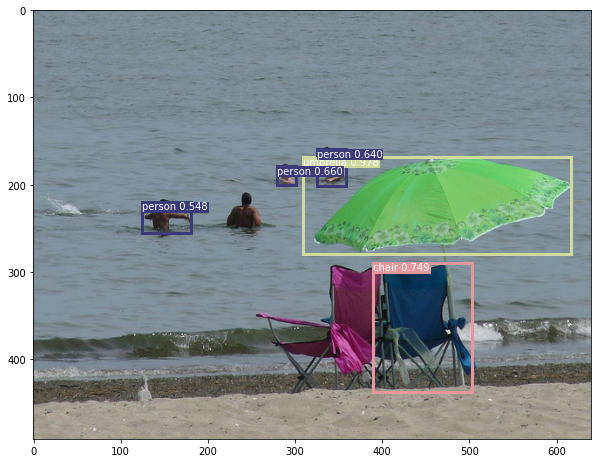

<Figure size 432x288 with 0 Axes>

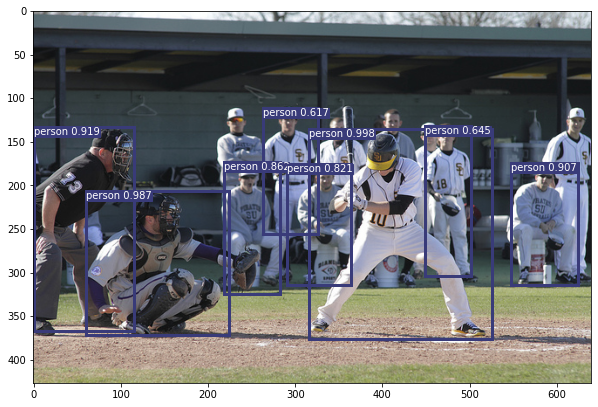

<Figure size 432x288 with 0 Axes>

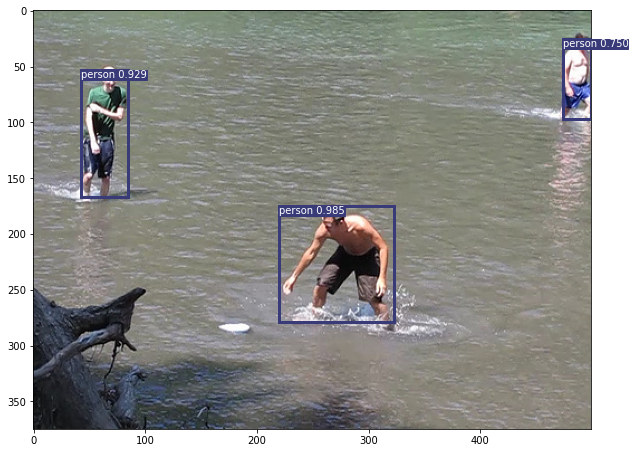

<Figure size 432x288 with 0 Axes>

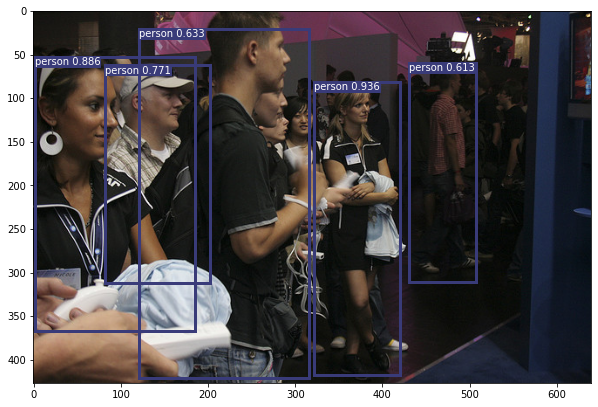

<Figure size 432x288 with 0 Axes>

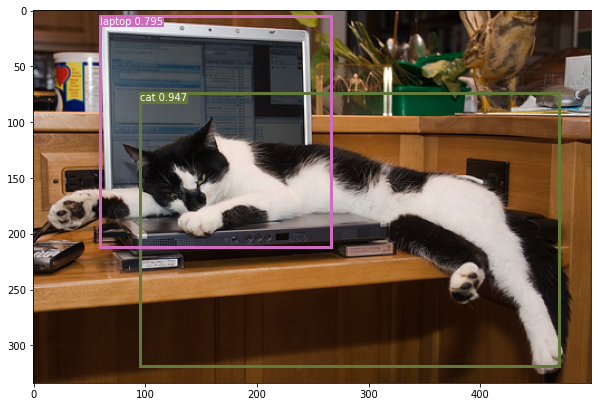

<Figure size 432x288 with 0 Axes>

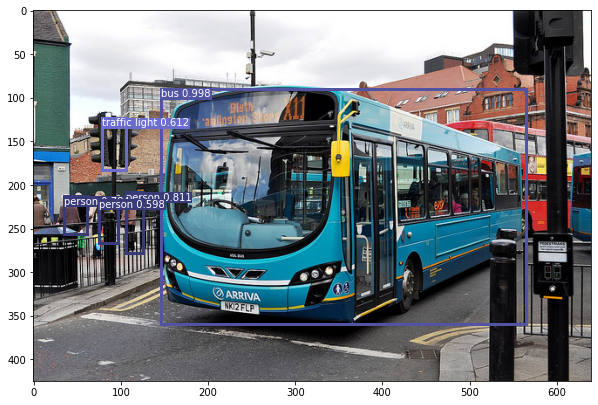

In [22]:
%matplotlib inline
import os, boto3, json
sagemaker_client = boto3.client('sagemaker-runtime')

path = "./images/test"
img_list = os.listdir(path)
img_list = [os.path.join(path, img) for img in img_list]
label_map = get_label_map('files/coco_labels.txt')

for img in img_list:
    pred = my_show_detection_result(img, endpoint_name, label_map)

## (Optional) Clean up

SageMaker Endpoint로 인한 과금을 막기 위해, 본 핸즈온이 끝나면 반드시 Endpoint를 삭제해 주시기 바랍니다.